In [ ]:
!conda install pandas -y

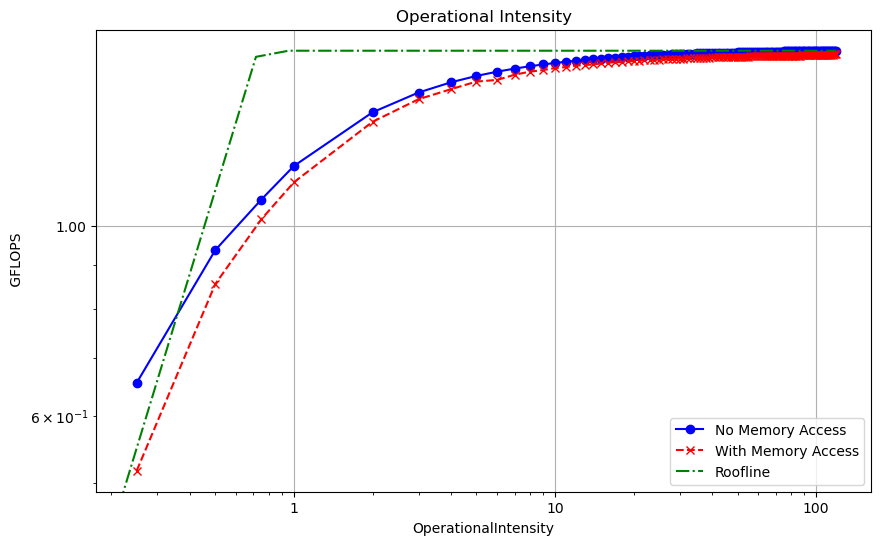

In [23]:
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
csv_file = "operational_intensity_ac6_hp_no_mem.csv"
data = pd.read_csv(csv_file)

# Plot the graph
x_column = data.columns[0]
y_column = data.columns[1]
# Load the second CSV file
csv_file_2 = "operational_intensity_ac6_hp_mem.csv"
data_2 = pd.read_csv(csv_file_2)
# Define the function
x_values = np.linspace(0, max(data[x_column]), 500)
y_values = np.minimum(2.2 * x_values, 1.6)

# Plot the function
# Add legend
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')
plt.title("Operational Intensity")
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.plot(data[x_column], data[y_column], marker='o', linestyle='-', color='b')
plt.plot(data_2[x_column], data_2[y_column], marker='x', linestyle='--', color='r', label='With Memory')
plt.plot(x_values, y_values, linestyle='-.', color='g', label='Roofline')
plt.legend(['No Memory Access', 'With Memory Access', 'Roofline'])
plt.show()

# Roofline
- $P = \min\{\pi, \beta \times I\}$
- $\pi$... peak performance
- $\beta$... peak bandwidth
- $I$... arithmetic intensity